In [1]:
# for ERA5 forecast diagnostics
# initial built: 2024/12/25

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import datetime
import os, shutil, sys
import subprocess
from glob import glob
import xarray as xr
import xesmf as xe
import netCDF4 as nc
import cartopy.crs as ccrs

sys.path.append('/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/GribDiag/lib')
import read_grib as rglib
import plot_grib as plib
import general_lib as glib


In [2]:
def getmask(readmask=False):
    """ create mask DataArray """

    print (f'analdir = {analdir}')
    masknc = f'{savedir}/mask.nc'
    print (f'masknc = {masknc}')
    
    if readmask and os.path.exists(masknc):
        mask = xr.load_dataset(masknc)['mask']
        pfull = mask.level.values

    else:
        """ get surface pressure from experiment forecast """
        fcstdate = sdate-datetime.timedelta(hours=6)
        fcstcyc  = fcstdate.strftime("%Y%m%d%H")
        fhr=fhrs[0]
        ne=0
        for e, eid in enumerate(expids):
            fcstfn = os.path.join(f'{fcsthome}/{expdic[eid]}',f'pgbf{fhr}.gfs.{fcstcyc}.grib2')
            plgrib = os.path.join(f'{workdir}', 'fcst.grib')
            fcstnc = os.path.join(f'{workdir}', 'fcst.nc')
            spgrib = os.path.join(f'{workdir}', 'fcstsp.grib')
            """ assuming all forecast files have the same dimension """
            if e == 0:
                if os.path.exists(plgrib):
                    os.remove(plgrib)
                subprocess.run(["grib_copy", "-w", "levtype=pl,shortName=t", fcstfn, plgrib])
                subprocess.run(["grib_to_netcdf", "-D" "NC_FLOAT", "-o", fcstnc, plgrib])
                fcst   = xr.load_dataset(fcstnc)
                ftime  = fcst.time.values[0]
                pfullf = fcst.level.values
                latf   = fcst.latitude.values
                lonf   = fcst.longitude.values
            if os.path.exists(spgrib):
                os.remove(spgrib)
            subprocess.run(["grib_copy", "-w", "shortName=sp", fcstfn, spgrib]) # sp = sea pressure
            fcstsp = xr.load_dataset(spgrib, engine="cfgrib")
            if e == 0:
                psfc = fcstsp.sp.values
            else:
                psfc = psfc + fcstsp.sp.values
            ne += 1

        """ get surface pressure from analysis """
        analcyc = sdate.strftime("%Y%m%d%H")
        ayyyy   = analcyc[:4]
        amm     = analcyc[4:6]
        
        analnc = os.path.join(analdir, f'{aprefix}.{era5fndic[varids[0]]}.{ayyyy}.{amm}.nc')
        spnc   = os.path.join(analdir, f'sfc.ps.{ayyyy}.{amm}.nc')

        """ get analysis pressure levels """
        if not os.path.exists(analnc):
            raise SystemExit(f'{analnc} not exist')
        anal   = xr.load_dataset(analnc).sel(valid_time=ftime)
        pfulla = anal.pressure_level.values
        
        """ analysis surface pressure """
        if not os.path.exists(spnc):
            raise SystemExit(f'{spnc} not exist')
        analsp = xr.load_dataset(spnc).sel(valid_time=ftime)
        
        """ regrid ERA5 dataset to forecast dataset resolution """
        lata = analsp.latitude.values
        lona = analsp.longitude.values

        if not np.array_equiv(lata,latf) or not np.array_equiv(lona,lonf):
            ds_out = xr.Dataset(
                {
                   "lat": (["lat"], latf),
                   "lon": (["lon"], lonf),
                }
            )
            regridder = xe.Regridder(analsp, ds_out, "bilinear")
            analsp = regridder(analsp)

        print (analsp.sp.values)
        psfc = psfc + analsp.sp.values
        ne += 1
        ne_inv=0.01/ne
        psfc = psfc * ne_inv

        psfcarray=xr.DataArray(
        data=psfc,
        coords={
            "latitude": latf,
            "longitude": lonf,
        },
        dims=["latitude", "longitude"],
        name='psfc'
        )

        psfcarray.to_netcdf(f'{savedir}/psfc.nc')
        
        """ create mask DataArray """
        maskdata = np.ones(fcst.t.values.shape, dtype=bool)
        pfull    = np.intersect1d(pfulla,pfullf)
        print ('pfulla ', pfulla)
        print ('pfullf ', pfullf)
        print ('pfull ', pfull)
        maskdata = np.ones((len(pfull), psfc.shape[0], psfc.shape[1]))
        for l, pres in enumerate(pfull.tolist()):
            cutoff=800
            if pres < cutoff:
                cutoff = pres
            maskdata[l,:,:] = (psfc > cutoff)

        mask=xr.DataArray(
        data=maskdata,
        coords={
            "level": pfull,
            "latitude": latf,
            "longitude": lonf,
        },
        dims=["level", "latitude", "longitude"],
        name='mask'
        )

        mask.to_netcdf(masknc)

    return mask

In [3]:
def read_anal(cdate,vtime,pfull,latf,lonf,anal0=None):
    """ read analysis and forecast data """

    readdata=True
    analcyc=cdate.strftime("%Y%m%d%H")
    print (f'analysis cycle {analcyc}')

    ayyyy=analcyc[:4]
    amm=analcyc[4:6]
    if anal0 is not None and vtime in anal0.time.values:
        print ('ERA5: skip reading analysis data')
        anal = anal0
        readdata=False
    else:
        for v, varid in enumerate(varids):
            if varid == 'vw' and not 'u' in varids and not 'v' in varids:
                analu = os.path.join(analdir, f'lev.ua.{ayyyy}.{amm}')
                analv = os.path.join(analdir, f'lev.va.{ayyyy}.{amm}')
                tmp = xr.load_dataset(analu).sel(pressure_level=pfull)
                if v == 0:
                    anal = tmp
                else:
                    anal = xr.merge([anal, tmp])
                tmp = xr.load_dataset(analv).sel(pressure_level=pfull)
                anal.merge(anal,tmp)
            else:
                analfn = os.path.join(analdir, f'{aprefix}.{era5fndic[varid]}.{ayyyy}.{amm}.nc')
                print (analfn)
                if levtype == 'isobaricInhPa' or levtype == 'heightAboveGround':
                    tmp = xr.load_dataset(analfn).sel(pressure_level=pfull)
                else:
                    """ single level data """
                    tmp = xr.load_dataset(analfn)
                    if varid == 'lcc':
                        tmp = tmp * 100.
                if v == 0:
                    anal = tmp
                else:
                    anal = xr.merge([anal, tmp])

        """ regrid dataset """
        lata=anal.latitude.values
        lona=anal.longitude.values
        if not np.array_equiv(lata,latf) or not np.array_equiv(lona,lonf):
            print ('regrid data')
            ds_out = xr.Dataset(
                {
                   "latitude": (["latitude"], latf),
                   "longitude": (["longitude"], lonf),
                }
            )
            regridder = xe.Regridder(anal, ds_out, "bilinear")
            anal = regridder(anal)

        """ rename variables """
        newname = {}
        for var in varids:
            if var in era5vardic.keys():
                key = era5vardic[var]
                newname[key] = var
        anal = anal.rename(name_dict=newname)
        anal = anal.rename({"pressure_level":"level", 'valid_time':'time'})

    return anal, readdata

In [4]:
def read_fcst(cdate,fhr,pfull):
    gdate = cdate - datetime.timedelta(hours=int(fhr))
    fcstcyc = gdate.strftime("%Y%m%d%H")
    fcst={}
    for e, eid in enumerate(expids):
        fcstfn = os.path.join(f'{fcsthome}/{expdic[eid]}',f'pgbf{fhr}.gfs.{fcstcyc}.grib2')
        print ('fcstfn: ', fcstfn)
        plgrib=os.path.join(f'{workdir}', 'fcst.grib')
        if os.path.exists(plgrib):
            os.remove(plgrib)
        if levtype == 'isobaricInhPa':
            subprocess.run(["grib_copy", "-w", f"typeOfLevel={levtype}", fcstfn, plgrib])

            # CCH: 2024/09/25:
            fcstnc=os.path.join(f'{workdir}', f'fcst.{fcstcyc}.nc')
            if os.path.exists(fcstnc):
                os.remove(fcstnc)
            subprocess.run(["grib_to_netcdf", "-D" "NC_FLOAT", "-o", fcstnc, plgrib])

            fcst[eid] = xr.load_dataset(fcstnc).sel(level=pfull).isel(time=0)[varids]
        else:
            """ single level data """
            vlist = []
            for varid in varids:
                subprocess.run(["grib_copy", "-w", f"shortName={varid},stepType={steptype}", fcstfn, plgrib])
                fcstnc=os.path.join(f'{workdir}', f'fcst.{fcstcyc}.nc')
                if os.path.exists(fcstnc):
                    os.remove(fcstnc)
                subprocess.run(["grib_to_netcdf", "-D" "NC_FLOAT", "-o", fcstnc, plgrib])
                ftmp = xr.load_dataset(fcstnc).isel(time=0)
                vlist.append(ftmp)
            if len(vlist) > 1:
                fcst[eid] = xr.merge(vlist)
            else:
                fcst[eid] = ftmp

    return fcst

In [5]:
def xarray_t_test_interval(ds,ci_coords,ci_dims,axis=0,alpha=0.95):

    """ get confidence interval for dataset:
        ds: input dataset
        ci_coords: input coordiates for output ci dataset
        ci_dims: input dims for output ci dataset """

    v = 0
    for var, da in ds.data_vars.items():
        #print (var, da.values.shape)
        hci = glib.t_test_interval(da.values,axis=axis,alpha=alpha)
        #print (hci.shape)
        tmp = xr.DataArray(hci, coords = ci_coords, dims = ci_dims, name=var)
        if v == 0:
            hci_xr = tmp
        else:
            hci_xr = xr.merge([hci_xr, tmp])
        v += 1

    return hci_xr

In [6]:
def compute_stats(fhr,mask,savedata=True):
    """ read forecast and analysis, compute variable mean, rmse, bias """

    fmean={}; ermse={}; ebias={}; zmean_rmse={}; dzmean_rmse={}; d95={}
    zmean_fma2={}; zmean_rmse={}; zmean_rmse_t={}
    ntime = 0
    cdate=sdate
    while cdate <= edate:
        """ 1. first read analysis and forecast data """
        fcst={}
        if mask is not None:
            pfull = mask.level.values
        else:
            pfull = None

        fcst  = read_fcst(cdate,fhr,pfull)
        ftime = fcst[expids[0]].time.values
        latf  = fcst[expids[0]].latitude.values
        lonf  = fcst[expids[0]].longitude.values

        if cdate == sdate:
            print ('read ERA5 data')
            analrd, readdata = read_anal(cdate,ftime,pfull,latf,lonf)
            anal0 = analrd
        else:
            analrd, readdata = read_anal(cdate,ftime,pfull,latf,lonf,anal0=anal0)
            if readdata:
                print ('read ERA5 data')
                anal0 = analrd
        print (analrd)
        print ('ffff ', ftime)
        
        if steptype == 'avg':
            ptime = []
            for dhr in np.arange(avghour)[::-1]:
                ptime.append(cdate-datetime.timedelta(hours=int(dhr)))
            anal = analrd.sel(time=ptime).mean(dim='time')
        else:
            anal = analrd.sel(time=ftime)
        print (anal)

        if ntime == 0:
            amean = anal
        else:
            amean += anal
            
        if mask is not None:
            amean = amean.where(mask)

        for e, exp in enumerate(expids):

            fma = fcst[exp] - anal

            if 'vw' in varids:
                vwfcst = np.sqrt(np.square(fcst[exp].u) + np.square(fcst[exp].v))
                if anal is not None:
                    vwanal = np.sqrt(np.square(anal.u) + np.square(anal.v))
                else:
                    if e == 0:
                        vwanal = vwfcst
                fma_vw = vwfcst - vwanal
                fma = xr.merge([fma,fma_vw])
                
            fma2 = fma*fma

            """ sum datasets over time """
            if ntime == 0:
                fmean[exp] = fcst[exp]
                ebias[exp] = fma
                ermse[exp] = fma2
                if mask is not None:
                    zmean_fma2[exp] = fma2.where(mask).mean(dim="longitude")
                else:
                    zmean_fma2[exp] = fma2.mean(dim="longitude")
            else:
                fmean[exp] += fcst[exp]
                ebias[exp] += fma
                ermse[exp] += fma2
                if mask is not None:
                    zmean_fma2[exp] = xr.concat([zmean_fma2[exp],fma2.where(mask).mean(dim="longitude")], "time")
                else:
                    zmean_fma2[exp] = xr.concat([zmean_fma2[exp],fma2.mean(dim="longitude")], "time")

            if mask is not None:
                #fmean[exp] = fcst[exp].where(mask)
                fmean[exp] = fmean[exp].where(mask)
                ebias[exp] = ebias[exp].where(mask)
                ermse[exp] = ermse[exp].where(mask)

        ntime += 1
        cdate += delta
    """ compute mean stats """
    """ https://www.tandfonline.com/doi/full/10.3402/tellusa.v68.30229 """

    rtime=1.0/ntime

    """ mean analysis """
    amean = amean * rtime

    """ mean forecast and forecast stats """
    for e, exp in enumerate(expids):
        fmean[exp] = fmean[exp] * rtime
        ebias[exp] = ebias[exp] * rtime
        ermse[exp] = np.sqrt(ermse[exp] * rtime)
        if "time" in zmean_fma2[exp].dims:
            zmean_rmse[exp] = np.sqrt(zmean_fma2[exp].mean(dim="time"))
        else:
            zmean_rmse[exp] = np.sqrt(zmean_fma2[exp])
        """ zonal mean rmse over n forecast """
        zmean_rmse_t[exp] = np.sqrt(zmean_fma2[exp])
        
    """ normalized zonal mean rmse difference """
    for e, exp in enumerate(expids[1:]):
        """ assuming the first experiment is the CNTL """
        drmse = zmean_rmse_t[exp] - zmean_rmse_t[expids[0]]
        if "time" in drmse.dims:
            drmse_tmean = drmse.mean(dim="time")
        else:
            drmse_tmean = drmse
        dzmean_rmse[exp] = drmse_tmean / zmean_rmse[expids[0]]
        if ntime < 10:
            d95[exp] = None
        else:
            if pfull is not None and levtype != 'surface' and levtype != 'unknown':
                ci_coords={"level": drmse.level.values,
                           "latitude": drmse.latitude.values}
                ci_dims=["level", "latitude"]
            else:
                ci_coords={"latitude": drmse.latitude.values}
                ci_dims=["latitude"]
            hci = xarray_t_test_interval(drmse,ci_coords,ci_dims,alpha=confidence_level)
            d95[exp] = hci / zmean_rmse[expids[0]]
            
    if savedata:
        amean.to_netcdf(f'{savedir}/analysis_mean_{vrfy}_f{fhr}.nc')
        for e, exp in enumerate(expids):
            fmean[exp].to_netcdf(f'{savedir}/fcst_mean_{exp}_f{fhr}.nc')
            ermse[exp].to_netcdf(f'{savedir}/rmse_{exp}_f{fhr}.nc')
            ebias[exp].to_netcdf(f'{savedir}/bias_{exp}_f{fhr}.nc')
            zmean_rmse[exp].to_netcdf(f'{savedir}/zmean_rmse_{exp}_f{fhr}.nc')
            if e > 0:
                dzmean_rmse[exp].to_netcdf(f'{savedir}/dzmean_rmse_{exp}_f{fhr}.nc')
                if ntime >= 10:
                    d95[exp].to_netcdf(f'{savedir}/d95_{exp}_f{fhr}.nc')
                else:
                    d95[exp]=None

    return amean, fmean, ermse, ebias, zmean_rmse, dzmean_rmse, d95

In [7]:
# main function starts below

global analhome, fcsthome, workhome, workdir, savedir, expdic
global sdate, edate, delta, vrfy, expids, varids, era5fndic, era5vardic, fhrs
global confidence_level, levtype, analdir, aprefix, steptype, avghour

era5fndic={'u': 'ua', 'v': 'va', 't': 't', 'q': 'qv', 'clwmr': 'qw',
            'ps': 'sp', 'lcc': 'lc'}
era5vardic={'clwmr': 'clwc', 'icmr': 'ciwc', 'rwmr': 'crwc', 'snmr': 'cswc'}

""" setup starts here """

""" 1. basic setup """
utildir  = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/'
fcsthome = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/archive/'
analhome = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/reanalysis_data/ERA5/1x1/'
workhome  = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work/'

fighome=utildir+'/figures'
savedir=utildir+'/data/'

if not os.path.exists(fighome):
    os.makedirs(fighome)
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(workhome):
    os.makedirs(workhome)

""" check/modify the following setup variables """
""" The first experiment provide analysis for the forecasts of 
    other experiments to compare with """

expdic={'IFS': 'ecm', 'gfs': 'gfs',
        'FC_ctrl':       'FC_ctrl',
        'FC_ctrl_noinf': 'FC_ctrl_noinf'
        }

expstr='FC_ctrl-FC_ctrl_noinf'
expids=expstr.split('-')
vrfy='ERA5'

#era5prefix='sfc'
#era5prefix='pbl'
era5prefix='lev'

fhrs=['06']
varids=['t']


""" levtype: isobaricInhPa, heightAboveGround, surface, unknown """
levtype='isobaricInhPa'
#levtype='unknown'

""" steptype: instant, avg, accum ... """
#steptype='avg'
steptype='instant'
avghour=6


""" if running the program again, can read data (.nc) that has been processed without 
reading grib files again """
readrawdata=True
savedata=True
read_mask=False

""" stats configuration """
confidence_level = 0.995

""" time period """
sdate=datetime.datetime(2022, 6, 20, 6)
edate=datetime.datetime(2022, 6, 21, 6)
dhour=24
delta = datetime.timedelta(hours=dhour)

In [8]:
expfix=expids[0]
for exp in expids[1:]:
    expfix += f'-{exp}'

daterange = f'{sdate.strftime("%Y%m%d%H")}_{edate.strftime("%Y%m%d%H")}_{dhour}'
savedir   = f'{savedir}/{expfix}/{daterange}/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

workdir = f'{workhome}/{expfix}/{daterange}/'
if not os.path.exists(workdir):
    os.makedirs(workdir)
else:
    print(f'caution: files already exist in {workdir}')
    #filelist = glob(os.path.join(workdir, "*"))
    #for f in filelist:
    #    os.remove(f)

analdir = analhome
aprefix = era5prefix

caution: files already exist in /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/


In [9]:
""" 1. create mask DataArray """
if levtype == 'isobaricInhPa':
    print ('create terrian mask')
    mask = getmask(readmask=read_mask)
    pfull = mask.level.values
else:
    mask = None

create terrian mask
analdir = /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/reanalysis_data/ERA5/1x1/
masknc = /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5//data//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24//mask.nc
grib_to_netcdf: Version 2.28.0
grib_to_netcdf: Processing input file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcst.grib'.
grib_to_netcdf: Found 36 GRIB fields in 1 file.
grib_to_netcdf: Ignoring key(s): method, type, stream, refdate, hdate
grib_to_netcdf: Creating netCDF file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcst.nc'
grib_to_netcdf: NetCDF library version: 4.8.1 of Oct 31 2022 22:17:45 $
grib_to_netcdf: Creating large (64 bit) file format.
grib_to_netcdf: Defining variable 't'.
grib_to_netcdf: Done.


Ignoring index file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcstsp.grib.923a8.idx' older than GRIB file
Ignoring index file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcstsp.grib.923a8.idx' older than GRIB file


[[100234.36 100234.36 100234.36 ... 100234.36 100234.36 100234.36]
 [100362.36 100363.36 100364.36 ... 100363.36 100363.36 100363.36]
 [100509.36 100505.36 100501.36 ... 100507.36 100505.36 100507.36]
 ...
 [ 69439.36  69369.36  69298.36 ...  69577.36  69533.36  69486.36]
 [ 68781.36  68758.36  68735.36 ...  68846.36  68825.36  68803.36]
 [ 67956.36  67956.36  67956.36 ...  67956.36  67956.36  67956.36]]
pfulla  [1000.  975.  950.  925.  900.  850.  800.  750.  700.  650.  600.  550.
  500.  450.  400.  350.  300.  250.  200.  150.  100.   50.   20.   10.]
pfullf  [   0    1    2    3    5    7   10   15   20   30   40   50   70  100
  150  200  250  300  350  400  450  500  550  600  650  700  750  800
  825  850  875  900  925  950  975 1000]
pfull  [  10.   20.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.
  550.  600.  650.  700.  750.  800.  850.  900.  925.  950.  975. 1000.]


In [ ]:
"""2. read data and compute error stats """
famean={}; ffmean={}; fbias={}; frmse={}; fzmean_rmse={}; fdzmean_rmse={}; fd95={}
for f, fhr in enumerate(fhrs):
    print (f'forecast hour {fhr}')
    if readrawdata:
        print ('read raw data and compute stats')
        amean, fmean, ermse, ebias, zmean_rmse, dzmean_rmse, d95 = compute_stats(fhr,mask,savedata=savedata)
    else:
        print ('read preprocessed stats')
        amean, fmean, ermse, ebias, zmean_rmse, dzmean_rmse, d95 = read_stats(fhr)

    famean[fhr]=amean; ffmean[fhr]=fmean; frmse[fhr]=ermse; fbias[fhr]=ebias
    fzmean_rmse[fhr]=zmean_rmse; fdzmean_rmse[fhr]=dzmean_rmse; fd95[fhr]=d95

    if f == 0:
        """  get area of lat/lon grid box """
        lat=amean.latitude.values
        lon=amean.longitude.values
        lath, latl, weight = glib.area_weight(lat,lon)

In [98]:
plt_var.shape

(24, 181, 360)

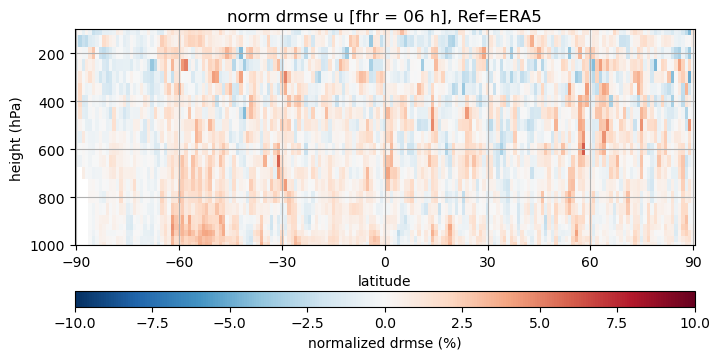

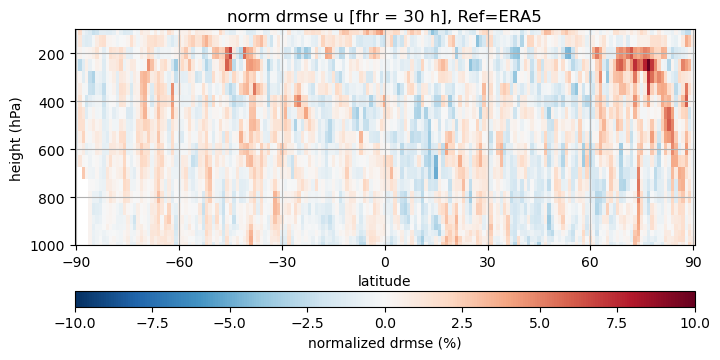

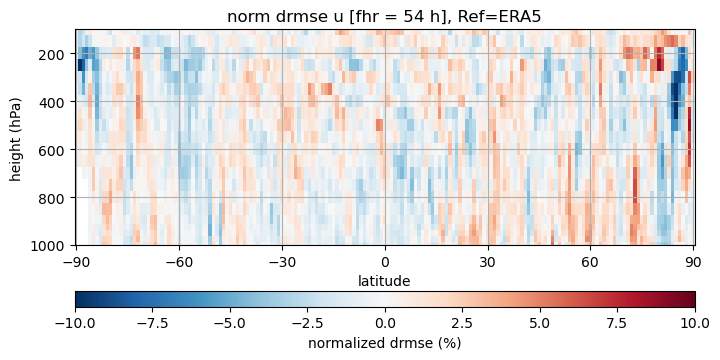

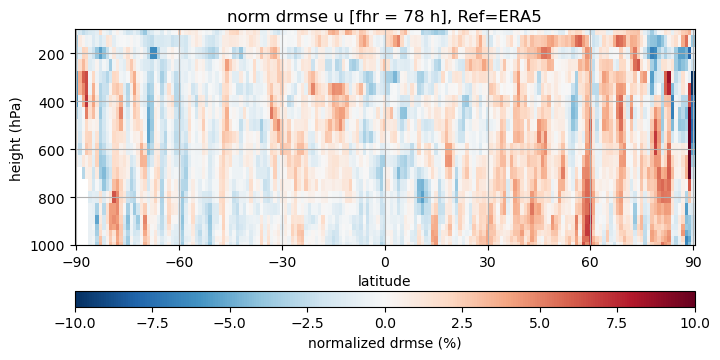

In [150]:
# Plot dzrmse (difference of zonal mean rmse in %)

diag_var = 'u'

for fhr in fhrs:

    plt_var = fdzmean_rmse[fhr]['FC_ctrl_noinf'][diag_var].values

    lats, levs = np.meshgrid(lat, pfull)

    fig, ax1 = plt.subplots(figsize=(8,4))

    contour1=ax1.pcolormesh(lats, levs, plt_var*100, cmap='RdBu_r', vmin=-10, vmax=10)
    ax1.invert_yaxis()
    #ax1.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
    ax1.set_xlabel('latitude')
    ax1.set_xticks([-90,-60,-30,0,30,60,90])

    ax1.set_ylabel('height (hPa)')
    ax1.set_title(f'norm drmse {diag_var} [fhr = {fhr} h], Ref=ERA5')
    ax1.set_ylim(1000,100)
    ax1.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour1,location='bottom',aspect=40)
    cbar.set_label('normalized drmse (%)')

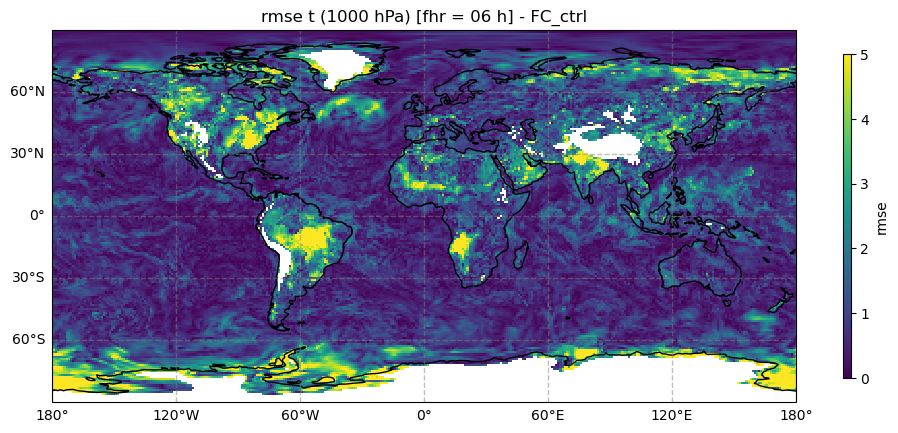

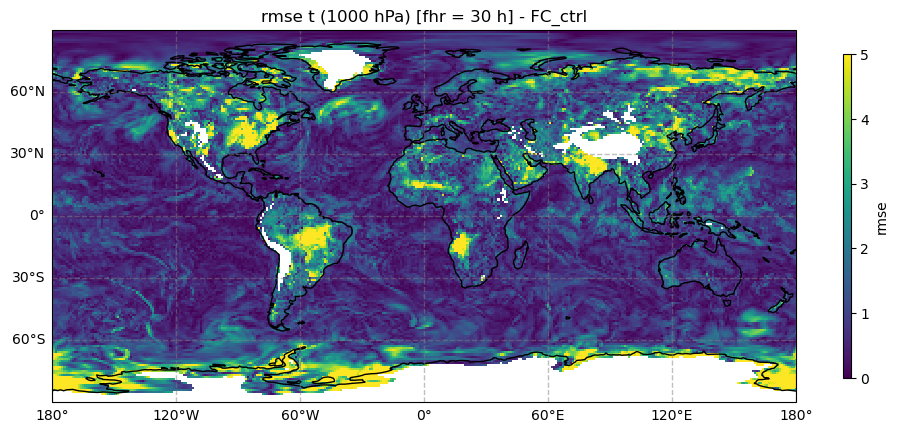

In [131]:
# Plot 2D map of CTRL RMSE

diag_var = 't'
vmin = 0
vmax = 5

plt_lev = -1

exp = expids[0]

for fhr in fhrs:
    plt_var = frmse[fhr][exp][diag_var].values
    lat = frmse[fhr][exp].latitude.values
    lon = frmse[fhr][exp].longitude.values
    lev = frmse[fhr][exp].level.values

    lonn, latt = np.meshgrid(lon,lat)

    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(projection=ccrs.PlateCarree())
    ax1.coastlines()

    contour1=ax1.pcolormesh(lonn, latt, plt_var[plt_lev,:,:].squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    #ax1.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
    ax1.set_xlabel('longitude')
    #ax1.set_xticks([-90,-60,-30,0,30,60,90])

    ax1.set_ylabel('latitude')
    ax1.set_title(f'rmse {diag_var} ({lev[plt_lev]} hPa) [fhr = {fhr} h] - {exp}')
    #ax1.set_ylim(1000,100)
    ax1.grid(True)
    gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40, shrink=0.6)
    cbar.set_label('rmse')

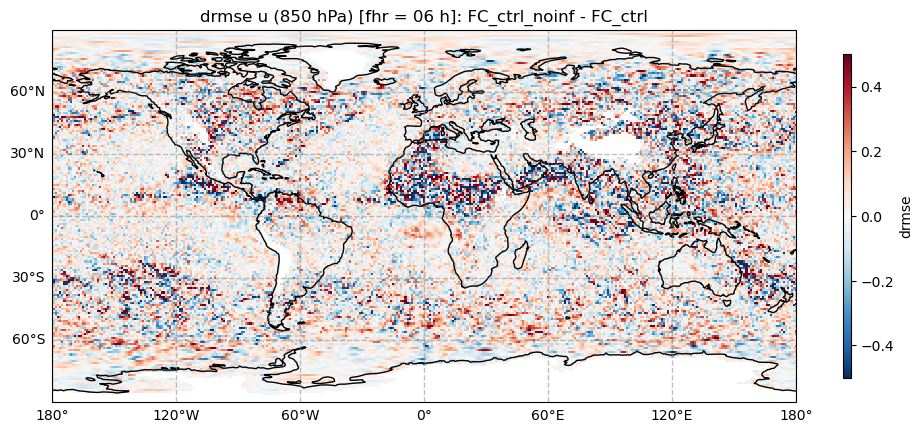

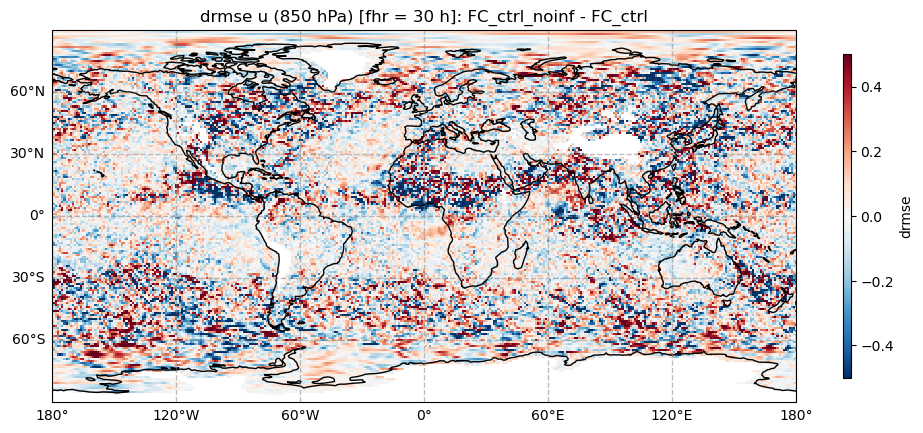

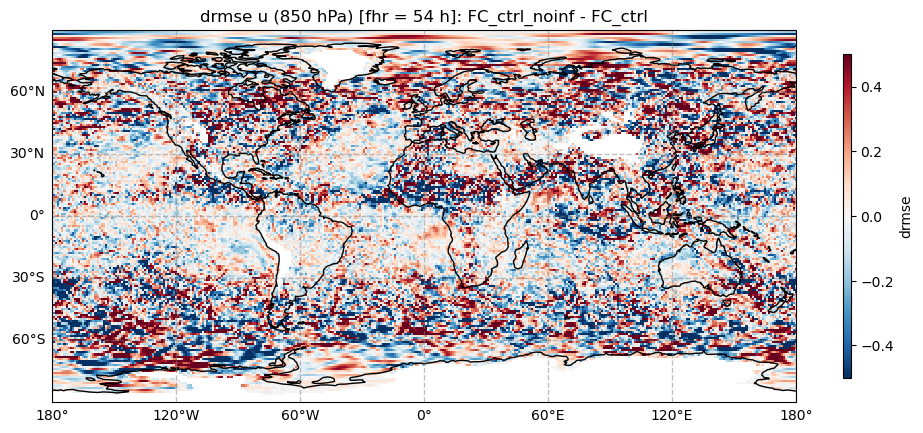

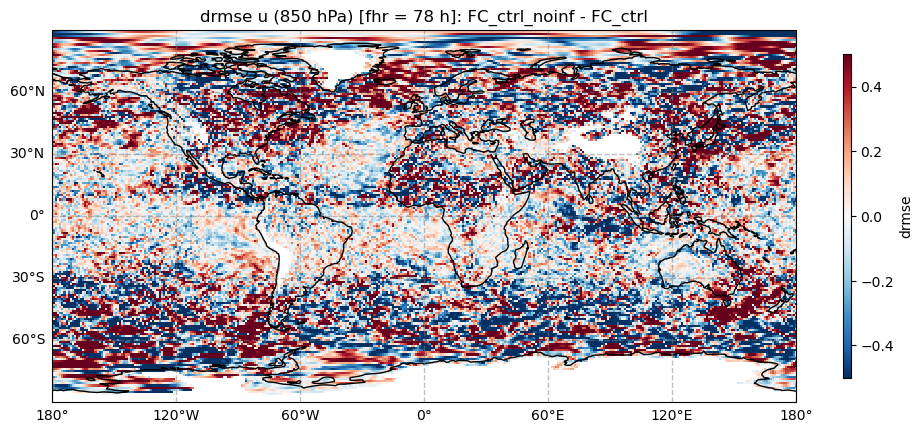

In [156]:
# Plot 2D map of dRMSE (exp - expref)

diag_var = 'u'
#vmin = -0.0005
#vmax =  0.0005

vmin = -0.5
vmax =  0.5

plt_lev = -6

for fhr in fhrs:
    for exp in expids[1:]:

        plt_var = frmse[fhr][exp][diag_var].values - frmse[fhr][expids[0]][diag_var].values
        lat = frmse[fhr][exp].latitude.values
        lon = frmse[fhr][exp].longitude.values
        lev = frmse[fhr][exp].level.values

        lonn, latt = np.meshgrid(lon,lat)

        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(projection=ccrs.PlateCarree())
        ax1.coastlines()

        contour1=ax1.pcolormesh(lonn, latt, plt_var[plt_lev,:,:].squeeze(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
        #ax1.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
        ax1.set_xlabel('longitude')
        #ax1.set_xticks([-90,-60,-30,0,30,60,90])

        ax1.set_ylabel('latitude')
        ax1.set_title(f'drmse {diag_var} ({lev[plt_lev]} hPa) [fhr = {fhr} h]: {exp} - {expids[0]}')
        #ax1.set_ylim(1000,100)
        ax1.grid(True)
        gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Hide labels on the top side
        gl.right_labels = False  # Hide labels on the right side

        # set colorbar
        cbar = fig.colorbar(contour1,location='right',aspect=40, shrink=0.6)
        cbar.set_label('drmse')

In [36]:
print (f'analdir = {analdir}')
masknc = f'{savedir}/mask.nc'
print (f'masknc = {masknc}')
    
""" get surface pressure from experiment forecast """
fcstdate = sdate-datetime.timedelta(hours=6)
fcstcyc  = fcstdate.strftime("%Y%m%d%H")
fhr=fhrs[0]
ne=0
for e, eid in enumerate(expids):
    fcstfn = os.path.join(f'{fcsthome}/{expdic[eid]}',f'pgbf{fhr}.gfs.{fcstcyc}.grib2')
    plgrib = os.path.join(f'{workdir}', 'fcst.grib')
    fcstnc = os.path.join(f'{workdir}', 'fcst.nc')
    spgrib = os.path.join(f'{workdir}', 'fcstsp.grib')
    """ assuming all forecast files have the same dimension """
    if e == 0:
        if os.path.exists(plgrib):
            os.remove(plgrib)
        subprocess.run(["grib_copy", "-w", "levtype=pl,shortName=t", fcstfn, plgrib])
        subprocess.run(["grib_to_netcdf", "-D" "NC_FLOAT", "-o", fcstnc, plgrib])
        fcst   = xr.load_dataset(fcstnc)
        ftime  = fcst.time.values[0]
        pfullf = fcst.level.values
        latf   = fcst.latitude.values
        lonf   = fcst.longitude.values
    if os.path.exists(spgrib):
        os.remove(spgrib)
    subprocess.run(["grib_copy", "-w", "shortName=sp", fcstfn, spgrib]) # sp = sea pressure
    fcstsp = xr.load_dataset(spgrib, engine="cfgrib")
    if e == 0:
        psfc = fcstsp.sp.values
    else:
        psfc = psfc + fcstsp.sp.values
    ne += 1

analdir = /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/reanalysis_data/ERA5/1x1/
masknc = /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5//data//FC_ctrl-FC_ctrl_noinf/2022061506_2022061606_24//mask.nc
grib_to_netcdf: Version 2.28.0
grib_to_netcdf: Processing input file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022061506_2022061606_24/fcst.grib'.
grib_to_netcdf: Found 36 GRIB fields in 1 file.
grib_to_netcdf: Ignoring key(s): method, type, stream, refdate, hdate
grib_to_netcdf: Creating netCDF file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022061506_2022061606_24/fcst.nc'
grib_to_netcdf: NetCDF library version: 4.8.1 of Oct 31 2022 22:17:45 $
grib_to_netcdf: Creating large (64 bit) file format.
grib_to_netcdf: Defining variable 't'.
grib_to_netcdf: Done.


Ignoring index file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022061506_2022061606_24/fcstsp.grib.923a8.idx' older than GRIB file
Ignoring index file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022061506_2022061606_24/fcstsp.grib.923a8.idx' older than GRIB file


In [65]:
""" get surface pressure from analysis """
analcyc = sdate.strftime("%Y%m%d%H")
ayyyy   = analcyc[:4]
amm     = analcyc[4:6]

analnc = os.path.join(analdir, f'{aprefix}.{era5fndic[varids[0]]}.{ayyyy}.{amm}.nc')
spnc   = os.path.join(analdir, f'sfc.ps.{ayyyy}.{amm}.nc')

""" get analysis pressure levels """
if not os.path.exists(analnc):
    raise SystemExit(f'{analnc} not exist')
anal   = xr.load_dataset(analnc).sel(valid_time=ftime)
pfulla = anal.pressure_level.values

""" analysis surface pressure """
if not os.path.exists(spnc):
    raise SystemExit(f'{spnc} not exist')
analsp = xr.load_dataset(spnc).sel(valid_time=ftime)

""" regrid ERA5 dataset to forecast dataset resolution """
lata = analsp.latitude.values
lona = analsp.longitude.values

if not np.array_equiv(lata,latf) or not np.array_equiv(lona,lonf):
    ds_out = xr.Dataset(
        {
           "lat": (["lat"], latf),
           "lon": (["lon"], lonf),
        }
    )
    regridder = xe.Regridder(analsp, ds_out, "bilinear")
    analsp = regridder(analsp)

print (analsp.sp.values)
psfc = psfc + analsp.sp.values
ne += 1
ne_inv=0.01/ne
psfc = psfc * ne_inv

psfcarray=xr.DataArray(
data=psfc,
coords={
    "latitude": latf,
    "longitude": lonf,
},
dims=["latitude", "longitude"],
name='psfc'
)

psfcarray.to_netcdf(f'{savedir}/psfc.nc')

""" create mask DataArray """
maskdata = np.ones(fcst.t.values.shape, dtype=bool)
pfull    = np.intersect1d(pfulla,pfullf)
print ('pfulla ', pfulla)
print ('pfullf ', pfullf)
print ('pfull ', pfull)
maskdata = np.ones((len(pfull), psfc.shape[0], psfc.shape[1]))
for l, pres in enumerate(pfull.tolist()):
    cutoff=800
    if pres < cutoff:
        cutoff = pres
    maskdata[l,:,:] = (psfc > cutoff)

mask=xr.DataArray(
data=maskdata,
coords={
    "level": pfull,
    "latitude": latf,
    "longitude": lonf,
},
dims=["level", "latitude", "longitude"],
name='mask'
)

mask.to_netcdf(masknc)


[[100286.516 100286.516 100286.516 ... 100286.516 100286.516 100286.516]
 [100638.516 100636.516 100634.516 ... 100647.516 100644.516 100641.516]
 [101006.516 100999.516 100991.516 ... 101012.516 101006.516 101006.516]
 ...
 [ 71428.516  71363.516  71298.516 ...  71550.516  71511.516  71470.516]
 [ 70808.516  70787.516  70767.516 ...  70866.516  70847.516  70828.516]
 [ 70013.516  70013.516  70013.516 ...  70013.516  70013.516  70013.516]]
pfulla  [1000.  975.  950.  925.  900.  850.  800.  750.  700.  650.  600.  550.
  500.  450.  400.  350.  300.  250.  200.  150.  100.   50.   20.   10.]
pfullf  [   0    1    2    3    5    7   10   15   20   30   40   50   70  100
  150  200  250  300  350  400  450  500  550  600  650  700  750  800
  825  850  875  900  925  950  975 1000]
pfull  [  10.   20.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.
  550.  600.  650.  700.  750.  800.  850.  900.  925.  950.  975. 1000.]


In [26]:
# compute stats::

""" read forecast and analysis, compute variable mean, rmse, bias """

fhr='06'

fmean={}; ermse={}; ebias={}; zmean_rmse={}; dzmean_rmse={}; d95={}; d95_regional={};
zmean_fma2={}; zmean_rmse={}; zmean_rmse_t={}; regional_rmse_t={}; regional_rmse_tmean={}; drgmean_rmse={};

fmean_ocean={}; ermse_ocean={}; ebias_ocean={}; zmean_rmse_ocean={}; dzmean_rmse_ocean={}; d95_ocean={}; d95_regional_ocean={};
zmean_fma2_ocean={}; zmean_rmse_ocean={}; zmean_rmse_t_ocean={}; regional_rmse_t_ocean={}; regional_rmse_tmean_ocean={};
drgmean_rmse_ocean={};

fmean_land={}; ermse_land={}; ebias_land={}; zmean_rmse_land={}; dzmean_rmse_land={}; d95_land={}; d95_regional_land={};
zmean_fma2_land={}; zmean_rmse_land={}; zmean_rmse_t_land={}; regional_rmse_t_land={}; regional_rmse_tmean_land={};
drgmean_rmse_land={};

ntime = 0
cdate=sdate

# read land/ocean mask:
mask_dir = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/land_ocean_mask'

land_mask  = xr.load_dataset(f"{mask_dir}/mask_land.nc")['land_mask_da']
ocean_mask = xr.load_dataset(f"{mask_dir}/mask_ocean.nc")['ocean_mask_da']


while cdate <= edate:
    """ 1. first read analysis and forecast data """
    fcst={}
    if mask is not None:
        pfull = mask.level.values
    else:
        pfull = None

    fcst  = read_fcst(cdate,fhr,pfull)
    ftime = fcst[expids[0]].time.values
    latf  = fcst[expids[0]].latitude.values
    lonf  = fcst[expids[0]].longitude.values

    if cdate == sdate:
        print ('read ERA5 data')
        analrd, readdata = read_anal(cdate,ftime,pfull,latf,lonf)
        anal0 = analrd
    else:
        analrd, readdata = read_anal(cdate,ftime,pfull,latf,lonf,anal0=anal0)
        if readdata:
            print ('read ERA5 data')
            anal0 = analrd
    print (analrd)
    print ('ffff ', ftime)

    if steptype == 'avg':
        ptime = []
        for dhr in np.arange(avghour)[::-1]:
            ptime.append(cdate-datetime.timedelta(hours=int(dhr)))
        anal = analrd.sel(time=ptime).mean(dim='valid_time')
    else:
        anal = analrd.sel(time=ftime)
    print (anal)

    if ntime == 0:
        amean = anal
    else:
        amean += anal

    if mask is not None:
        amean = amean.where(mask)

    for e, exp in enumerate(expids):

        fma = fcst[exp] - anal

        if 'vw' in varids:
            vwfcst = np.sqrt(np.square(fcst[exp].u) + np.square(fcst[exp].v))
            if anal is not None:
                vwanal = np.sqrt(np.square(anal.u) + np.square(anal.v))
            else:
                if e == 0:
                    vwanal = vwfcst
            fma_vw = vwfcst - vwanal
            fma = xr.merge([fma,fma_vw])
            
        fma2 = fma*fma

        """ sum datasets over time """
        if ntime == 0:
            fmean[exp] = fcst[exp]
            ebias[exp] = fma
            ermse[exp] = fma2
            if mask is not None:
                zmean_fma2[exp] = fma2.where(mask).mean(dim="longitude")
                zmean_fma2_ocean[exp] = fma2.where(mask).where(ocean_mask).mean(dim="longitude")
                zmean_fma2_land [exp] = fma2.where(mask).where(land_mask).mean(dim="longitude")
                
            else:
                zmean_fma2[exp] = fma2.mean(dim="longitude")
                zmean_fma2_ocean[exp] = fma2.where(ocean_mask).mean(dim="longitude")
                zmean_fma2_land [exp] = fma2.where(land_mask).mean(dim="longitude")
                
        else:
            fmean[exp] += fcst[exp]
            ebias[exp] += fma
            ermse[exp] += fma2
            if mask is not None:
                zmean_fma2[exp] = xr.concat([zmean_fma2[exp],fma2.where(mask).mean(dim="longitude")], "time")
                zmean_fma2_ocean[exp] = xr.concat([zmean_fma2_ocean[exp],fma2.where(mask).where(ocean_mask).mean(dim="longitude")], "time")
                zmean_fma2_land [exp] = xr.concat([zmean_fma2_land [exp],fma2.where(mask).where(land_mask).mean(dim="longitude")], "time")

            else:
                zmean_fma2[exp] = xr.concat([zmean_fma2[exp],fma2.mean(dim="longitude")], "time")
                zmean_fma2_ocean[exp] = xr.concat([zmean_fma2_ocean[exp],fma2.where(ocean_mask).mean(dim="longitude")], "time")
                zmean_fma2_land [exp] = xr.concat([zmean_fma2_land [exp],fma2.where(land_mask).mean(dim="longitude")], "time")

        if mask is not None:
            #fmean[exp] = fcst[exp].where(mask)
            fmean[exp] = fmean[exp].where(mask)
            ebias[exp] = ebias[exp].where(mask)
            ermse[exp] = ermse[exp].where(mask)
            
            fmean_ocean[exp] = fmean[exp].where(ocean_mask)
            fmean_land [exp] = fmean[exp].where(land_mask)
            
            ebias_ocean[exp] = ebias[exp].where(ocean_mask)
            ebias_land [exp] = ebias[exp].where(land_mask)
            
            ermse_ocean[exp] = ermse[exp].where(ocean_mask)
            ermse_land [exp] = ermse[exp].where(land_mask)
            
    ntime += 1
    cdate += delta
""" compute mean stats """
""" https://www.tandfonline.com/doi/full/10.3402/tellusa.v68.30229 """

rtime=1.0/ntime

""" mean analysis """
amean = amean * rtime

""" mean forecast and forecast stats """
for e, exp in enumerate(expids):
    
    # initialize:
    regional_rmse_t[exp] = {};
    regional_rmse_t_ocean[exp] = {};
    regional_rmse_t_land[exp] = {};

    regional_rmse_tmean[exp] = {};
    regional_rmse_tmean_ocean[exp] = {};
    regional_rmse_tmean_land[exp] = {};
    
    
    
    fmean[exp] = fmean[exp] * rtime
    fmean_ocean[exp] = fmean_ocean[exp] * rtime
    fmean_land [exp] = fmean_land [exp] * rtime
    
    ebias[exp] = ebias[exp] * rtime
    ebias_ocean[exp] = ebias_ocean[exp] * rtime
    ebias_land [exp] = ebias_land [exp] * rtime
    
    ermse[exp] = np.sqrt(ermse[exp] * rtime)
    ermse_ocean[exp] = np.sqrt( ermse_ocean[exp] * rtime )
    ermse_land [exp] = np.sqrt( ermse_land [exp] * rtime )   
    
    if "time" in zmean_fma2[exp].dims:
        zmean_rmse[exp] = np.sqrt(zmean_fma2[exp].mean(dim="time"))
        zmean_rmse_ocean[exp] = np.sqrt(zmean_fma2_ocean[exp].mean(dim="time"))
        zmean_rmse_land [exp] = np.sqrt(zmean_fma2_land [exp].mean(dim="time"))
    else:
        zmean_rmse[exp] = np.sqrt(zmean_fma2[exp])
        zmean_rmse_ocean[exp] = np.sqrt(zmean_fma2_ocean[exp])
        zmean_rmse_land [exp] = np.sqrt(zmean_fma2_land [exp])
        
    """ zonal mean rmse over n forecast """
    zmean_rmse_t[exp] = np.sqrt(zmean_fma2[exp])
    zmean_rmse_t_ocean[exp] = np.sqrt(zmean_fma2_ocean[exp])
    zmean_rmse_t_land [exp] = np.sqrt(zmean_fma2_land [exp])
    
    """ global mean rmse over n forecast """
    for avg_region in ['global','NH','SH','TR']:
        # area weighted average:
        lat = fcst[expids[0]].coords['latitude']
        weights = np.cos(np.deg2rad(lat))
        
        if avg_region == 'global':
            weights = weights / weights.sum() # Normalize weights so they sum to 1
        elif avg_region == 'NH':
            weights = weights.where((weights.latitude > 20), 0)
            weights = weights / weights.sum()
        elif avg_region == 'SH':
            weights = weights.where((weights.latitude < -20), 0)
            weights = weights / weights.sum()
        elif avg_region == 'TR':
            weights = weights.where((weights.latitude > -20) & (weights.latitude < 20), 0)
            weights = weights / weights.sum()
        
        regional_rmse_t[exp][avg_region] = zmean_rmse_t[exp].weighted(weights).mean(dim='latitude') # Perform weighted average over latitude
        regional_rmse_t_ocean[exp][avg_region] = zmean_rmse_t_ocean[exp].weighted(weights).mean(dim='latitude') # Perform weighted average over latitude
        regional_rmse_t_land [exp][avg_region] = zmean_rmse_t_land [exp].weighted(weights).mean(dim='latitude') # Perform weighted average over latitude

        regional_rmse_tmean[exp][avg_region] = regional_rmse_t[exp][avg_region].mean(dim="time")
        regional_rmse_tmean_ocean[exp][avg_region] = regional_rmse_t_ocean[exp][avg_region].mean(dim="time")
        regional_rmse_tmean_land[exp][avg_region]  = regional_rmse_t_land[exp][avg_region].mean(dim="time")

""" normalized zonal/global mean rmse difference """
for e, exp in enumerate(expids[1:]):
    
    # initialize:
    drmse_regional = {};
    drmse_regional_ocean = {};
    drmse_regional_land = {};
    
    drmse_regional_tmean = {};
    drmse_regional_tmean_ocean = {};
    drmse_regional_tmean_land = {};
    
    drgmean_rmse[exp] = {};
    drgmean_rmse_ocean[exp] = {};
    drgmean_rmse_land [exp] = {};
    
    d95_regional[exp] = {};
    d95_regional_ocean[exp] = {};
    d95_regional_land [exp] = {};
    
    """ assuming the first experiment is the CNTL """
    drmse = zmean_rmse_t[exp] - zmean_rmse_t[expids[0]]
    drmse_ocean = zmean_rmse_t_ocean[exp] - zmean_rmse_t_ocean[expids[0]]
    drmse_land  = zmean_rmse_t_land [exp] - zmean_rmse_t_land [expids[0]]
    
    for avg_region in ['global','NH','SH','TR']:
        drmse_regional[avg_region] = regional_rmse_t[exp][avg_region] - regional_rmse_t[expids[0]][avg_region]
        drmse_regional_ocean[avg_region] = regional_rmse_t_ocean[exp][avg_region] - regional_rmse_t_ocean[expids[0]][avg_region]
        drmse_regional_land[avg_region]  = regional_rmse_t_land [exp][avg_region] - regional_rmse_t_land [expids[0]][avg_region]

    if "time" in drmse.dims:
        drmse_tmean = drmse.mean(dim="time")
        drmse_tmean_ocean = drmse_ocean.mean(dim="time")
        drmse_tmean_land  = drmse_land.mean(dim="time")
        
        for avg_region in ['global','NH','SH','TR']:
            drmse_regional_tmean[avg_region] = drmse_regional[avg_region].mean(dim="time")
            drmse_regional_tmean_ocean[avg_region] = drmse_regional_ocean[avg_region].mean(dim="time")
            drmse_regional_tmean_land[avg_region]  = drmse_regional_land[avg_region].mean(dim="time")

    else:
        drmse_tmean = drmse
        drmse_tmean_ocean = drmse_ocean
        drmse_tmean_land  = drmse_land
        
        for avg_region in ['global','NH','SH','TR']:
            drmse_regional_tmean[avg_region] = drmse_regional[avg_region]
            drmse_regional_tmean_ocean[avg_region] = drmse_regional_ocean[avg_region]
            drmse_regional_tmean_land[avg_region]  = drmse_regional_land[avg_region]

    # normalized zonal mean:
    dzmean_rmse[exp] = drmse_tmean / zmean_rmse[expids[0]]
    dzmean_rmse_ocean[exp] = drmse_tmean_ocean / zmean_rmse_ocean[expids[0]]
    dzmean_rmse_land [exp] = drmse_tmean_land  / zmean_rmse_land [expids[0]]
    
    # normalized regional mean:
    for avg_region in ['global','NH','SH','TR']:
        drgmean_rmse[exp][avg_region] = drmse_regional_tmean[avg_region] / regional_rmse_tmean[expids[0]][avg_region]
        drgmean_rmse_ocean[exp][avg_region] = drmse_regional_tmean_ocean[avg_region] / regional_rmse_tmean_ocean[expids[0]][avg_region]
        drgmean_rmse_land [exp][avg_region] = drmse_regional_tmean_land[avg_region] / regional_rmse_tmean_land[expids[0]][avg_region]

    if ntime < 2:
        d95[exp] = None
    else:
        # t-test for zonal mean:
        if pfull is not None and levtype != 'surface' and levtype != 'unknown':
            ci_coords={"level": drmse.level.values,
                       "latitude": drmse.latitude.values}
            ci_dims=["level", "latitude"]
        else:
            ci_coords={"latitude": drmse.latitude.values}
            ci_dims=["latitude"]
        hci = xarray_t_test_interval(drmse,ci_coords,ci_dims,alpha=confidence_level)
        hci_ocean = xarray_t_test_interval(drmse_ocean,ci_coords,ci_dims,alpha=confidence_level)
        hci_land  = xarray_t_test_interval(drmse_land ,ci_coords,ci_dims,alpha=confidence_level)

        d95[exp] = hci / zmean_rmse[expids[0]]
        d95_ocean[exp] = hci_ocean / zmean_rmse_ocean[expids[0]]
        d95_land [exp] = hci_land  / zmean_rmse_land [expids[0]]
        
        # t-test for regional mean:
        ci_coords={"level": drmse.level.values}
        ci_dims=["level"]

        for avg_region in ['global','NH','SH','TR']:
            hci = xarray_t_test_interval(drmse_regional[avg_region],ci_coords,ci_dims,alpha=confidence_level)
            hci_ocean = xarray_t_test_interval(drmse_regional_ocean[avg_region],ci_coords,ci_dims,alpha=confidence_level)
            hci_land  = xarray_t_test_interval(drmse_regional_land[avg_region] ,ci_coords,ci_dims,alpha=confidence_level)

            d95_regional[exp][avg_region] = hci / regional_rmse_tmean[expids[0]][avg_region]
            d95_regional_ocean[exp][avg_region] = hci_ocean / regional_rmse_tmean_ocean[expids[0]][avg_region]
            d95_regional_land [exp][avg_region] = hci_land  / regional_rmse_tmean_land [expids[0]][avg_region]

fcstfn:  /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/archive//FC_ctrl/pgbf06.gfs.2022062000.grib2
grib_to_netcdf: Version 2.28.0
grib_to_netcdf: Processing input file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcst.grib'.
grib_to_netcdf: Found 494 GRIB fields in 1 file.
grib_to_netcdf: Ignoring key(s): method, type, stream, refdate, hdate
grib_to_netcdf: Creating netCDF file '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/work//FC_ctrl-FC_ctrl_noinf/2022062006_2022062106_24/fcst.2022062000.nc'
grib_to_netcdf: NetCDF library version: 4.8.1 of Oct 31 2022 22:17:45 $
grib_to_netcdf: Creating large (64 bit) file format.
grib_to_netcdf: Defining variable 'gh'.
grib_to_netcdf: Defining variable 't'.
grib_to_netcdf: Defining variable 'r'.
grib_to_netcdf: Defining variable 'q'.
grib_to_netcdf: Defining variable 'w'.
grib_to_netcdf: Defining variable 'wz'.
grib_to_netcdf: Defining variable 'u'.
grib_to_netcdf: Defini

In [30]:
drgmean_rmse['FC_ctrl_noinf']['global']

<xarray.Dataset>
Dimensions:  (level: 24)
Coordinates:
  * level    (level) int32 10 20 50 100 150 200 250 ... 850 900 925 950 975 1000
Data variables:
    t        (level) float32 -0.0007221 0.003655 ... -0.002493 -0.001973

In [23]:
weights_tropics = weights.where((weights.latitude > -20) & (weights.latitude < 20), 0)
global_rmse_t[exp] = zmean_rmse_t[exp].weighted(weights_tropics).mean(dim='latitude')

In [22]:
weights_tropics

<xarray.DataArray 'latitude' (latitude: 181)>
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00825142, 0.00829974, 0.00834554, 0.0083888 ,
       0.00842951, 0.00846764, 0.0085032 , 0.00853616, 0.00856653,
       0.00859429, 0.00861943, 0.00864194, 0.00866182, 0.00867906,
       0.00869366, 0.00870561, 0.00871491, 0.00872155, 0.00872554,
       0.00872687, 0.00872554, 0.00872155, 0.00871491, 0.00870561,
       0.00869366, 0.00867906, 0.00866182, 0.00864194, 0.00861943,
       0.00859429, 0.00856653, 0.00853616, 0.0085032 , 0.00846764,
       0.00842951, 0.0083888 , 0.00834554, 0.00829974, 0.00825142,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    time      datetime64[ns] 2022-06-21T06:00:00
Attributes:
    units:      degrees_north
    long_name:  latitude

In [178]:
passed = np.abs(d95_global['FC_ctrl_noinf']['t'].values/dgmean_rmse['FC_ctrl_noinf']['t'].values) >1

In [179]:
passed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False])

In [164]:
global_rmse_tmean[expids[0]]['t'].values

array([1.1783779 , 0.92209166, 0.77372926, 0.8057593 , 0.64523816,
       0.63597953, 0.6008069 , 0.52819073, 0.5179217 , 0.5407176 ,
       0.5522474 , 0.56444913, 0.5812893 , 0.5940135 , 0.6301267 ,
       0.6841094 , 0.78033775, 0.9072964 , 1.0989189 , 1.102632  ,
       1.1358719 , 1.2362909 , 1.3539623 , 1.4631757 ], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


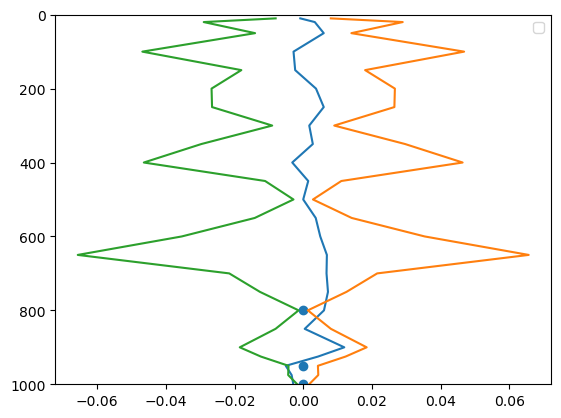

In [180]:
plt.plot(drmse_global_tmean['t'].values, levs)
#plt.plot(drmse_global_tmean['t'].values, levs,  label='drmse')
#plt.plot(hci.values, levs,  label='confidence interval')
#plt.plot(-hci.values, levs,  label='confidence interval')
plt.plot(hci.values, levs)
plt.plot(-hci.values, levs)
plt.scatter(np.zeros(len(levs)), np.ma.array(levs, mask=passed))
plt.ylim(1000,0)
plt.legend()

In [147]:
hh

array([0.00578521, 0.03408258, 0.02341599, 0.07218894, 0.04329815,
       0.06601314, 0.07356777, 0.03238582, 0.1106521 , 0.15880789,
       0.03640264, 0.0089141 , 0.04178677, 0.10023518, 0.16539672,
       0.04604075, 0.02069402, 0.0016335 , 0.00667089, 0.01519871,
       0.00956456, 0.00280113, 0.00239324, 0.00080727])

In [146]:
hh = np.abs(d95_global['FC_ctrl_noinf']['t'].values/

In [134]:
dgmean_rmse['FC_ctrl_noinf']['t'].values

array([-7.2205724e-04,  3.6552697e-03,  7.7288593e-03, -3.5047792e-03,
       -3.6323243e-03,  5.8517526e-03,  9.9526113e-03,  3.3217589e-03,
        5.3963596e-03, -5.9146341e-03,  2.6366478e-03, -3.3791330e-06,
        6.2657809e-03,  8.3537921e-03,  1.0934071e-02,  9.9216281e-03,
        9.2388839e-03,  6.6688419e-03,  3.9719473e-04,  1.0847070e-02,
        3.7957118e-03, -4.1125724e-03, -2.4931196e-03, -1.9731128e-03],
      dtype=float32)

In [135]:
hh

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

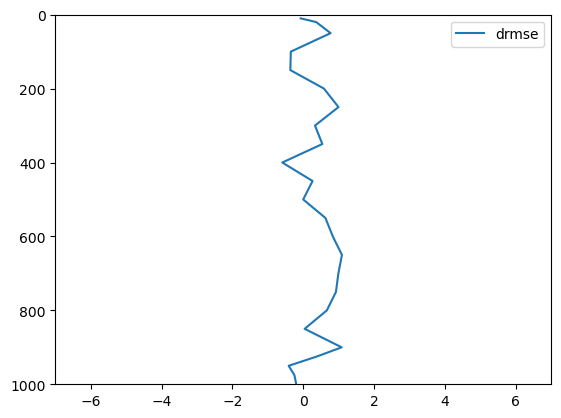

In [130]:
plt.plot(dgmean_rmse['FC_ctrl_noinf']['t'].values*100, levs,  label='drmse')
#plt.plot( hh, levs,  label='confidence interval')
#plt.plot(-hh, levs,  label='confidence interval')
plt.xlim(-7, 7)
plt.ylim(1000,0)
plt.legend()

In [99]:
drmse_mean['t'].values

array([-8.5085630e-04,  3.3704937e-03,  5.9800446e-03, -2.8240085e-03,
       -2.3437142e-03,  3.7215948e-03,  5.9795976e-03,  1.7545223e-03,
        2.7948916e-03, -3.1981468e-03,  1.4560819e-03, -1.9073486e-06,
        3.6422312e-03,  4.9622655e-03,  6.8898499e-03,  6.7874789e-03,
        7.2094500e-03,  6.0506165e-03,  4.3648481e-04,  1.1960328e-02,
        4.3114424e-03, -5.0843358e-03, -3.3755898e-03, -2.8870106e-03],
      dtype=float32)

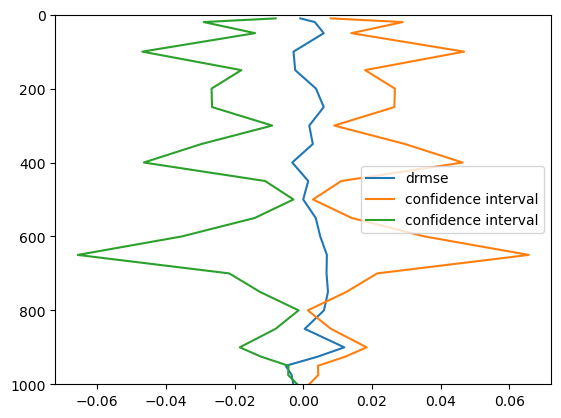

In [102]:
plt.plot(drmse_mean['t'].values, levs,  label='drmse')
plt.plot( hci.values, levs,  label='confidence interval')
plt.plot(-hci.values, levs,  label='confidence interval')

plt.ylim(1000,0)
plt.legend()

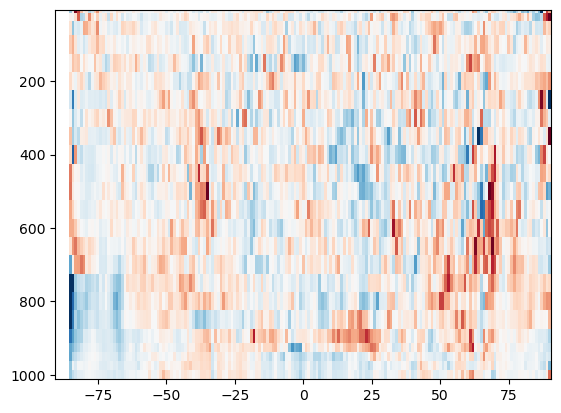

In [141]:
lats, levs = np.meshgrid(latf, levf)

tmp = dzmean_rmse_ocean['FC_ctrl_noinf'].t.values
plt.pcolormesh(lats, levs, tmp, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
plt.gca().invert_yaxis()


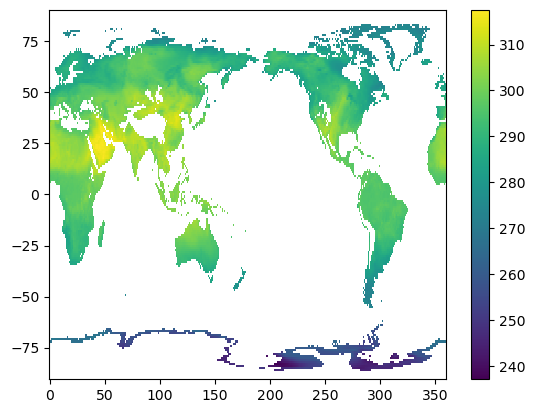

In [121]:
tmp = dzrmse['FC_ctrl'].t.values[-1,:,:]
plt.pcolormesh(lons, lats, tmp.T)
plt.colorbar()

In [101]:
mask_dir = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/land_ocean_mask'

land_mask  = xr.load_dataset(f"{mask_dir}/mask_land.nc")['land_mask_da']
ocean_mask = xr.load_dataset(f"{mask_dir}/mask_ocean.nc")['ocean_mask_da']

In [111]:
aaa = fcst[expids[0]]
bbb = fcst[expids[0]].where(mask).where(land_mask_da)

tmp1 = aaa.isel(level=23)
tmp2 = bbb.isel(level=23)

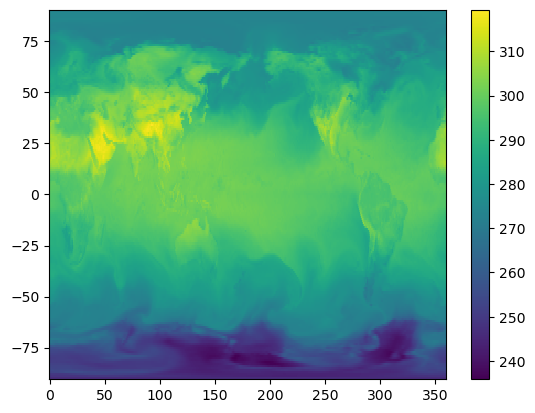

In [112]:
tmp11 = tmp1.t.values
plt.pcolormesh(lons, lats, tmp11.T)
plt.colorbar()

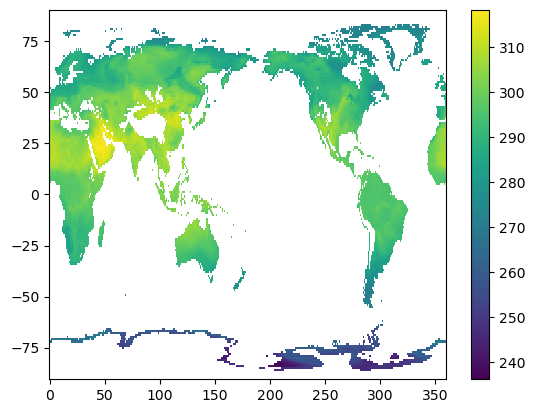

In [113]:
tmp22 = tmp2.t.values
plt.pcolormesh(lons, lats, tmp22.T)
plt.colorbar()

In [26]:
fma.level.values

array([  10,   20,   50,  100,  150,  200,  250,  300,  350,  400,  450,
        500,  550,  600,  650,  700,  750,  800,  850,  900,  925,  950,
        975, 1000], dtype=int32)

In [42]:
levf = fcst[expids[0]].level.values

In [43]:
levf

array([  10,   20,   50,  100,  150,  200,  250,  300,  350,  400,  450,
        500,  550,  600,  650,  700,  750,  800,  850,  900,  925,  950,
        975, 1000], dtype=int32)

In [97]:
from global_land_mask import globe


lats, lons = np.meshgrid(latf,lonf)

lon_shift = lonf.copy()
for i, llon in enumerate(lon_shift):
    if llon > 180:
        lon_shift[i] = lonf[i] - 360
        
lats, lons_shift = np.meshgrid(latf, lon_shift)

ocean_mask = globe.is_ocean(lats, lons_shift)
land_mask  = globe.is_land(lats, lons_shift)

land_mask_levs  = np.tile(land_mask.T,  (len(levf), 1, 1)) 
ocean_mask_levs = np.tile(ocean_mask.T, (len(levf), 1, 1)) 

# Step 4: Wrap the mask in an xarray.DataArray
land_mask_da = xr.DataArray(
    data=land_mask_levs,
    coords={"level": levf, "latitude": latf, "longitude": lonf},
    dims=("level", "latitude", "longitude"),
    name="land_mask_da"
)

ocean_mask_da = xr.DataArray(
    data=ocean_mask_levs,
    coords={"level": levf, "latitude": latf, "longitude": lonf},
    dims=("level", "latitude", "longitude"),
    name="ocean_mask_da"
)

In [98]:
#aaa = fcst[expids[0]].where(land_mask_da)
#aaa = fcst[expids[0]]
#aaa = fma.where(mask)
aaa = fma.where(mask).where(ocean_mask_da)

In [99]:
tmp1 = aaa.isel(level=23)

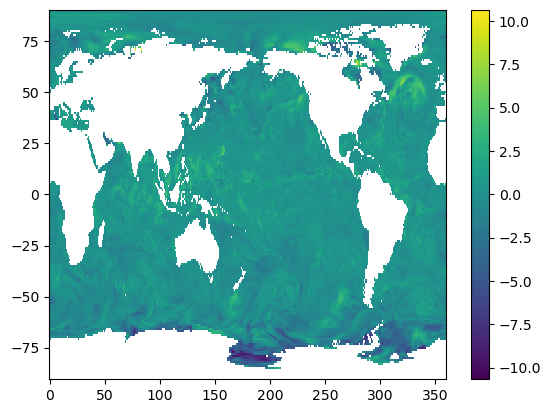

In [100]:
tmp2 = tmp1.t.values
plt.pcolormesh(lons, lats, tmp2.T)
plt.colorbar()

In [ ]:
tmp3 = fma

In [62]:
tmp2

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    level      int32 10
    time       datetime64[ns] 2022-06-21T06:00:00
Data variables:
    t          (latitude, longitude) float32 nan nan nan ... -0.7928 -0.7928>